In [81]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite, community
import math
from collections import Counter
import numpy as np

DATA_DIR = '../../data/'
YEAR = 2021
THRESHOLD = 6

stock_tx =  pd.read_csv(f'{DATA_DIR}cleaned/2021-2023/stocks.csv')
stock_tx = stock_tx[stock_tx['year'] == YEAR]

print(stock_tx["sector"].unique())

stock_tx.head()


['Energy' 'Real Estate' 'Consumer Non-Durables' 'Finance' 'Technology'
 'Public Utilities' 'Consumer Staples' nan 'Health Care' 'Utilities'
 'Consumer Discretionary' 'Capital Goods' 'Consumer Services'
 'Miscellaneous' 'Telecommunications' 'Basic Industries'
 'Consumer Durables' 'Transportation' 'Industrials' 'Basic Materials']


,transaction_date,ticker,asset_description,type,amount,state,ptr_link,industry,sector,party,chamber,member,year,last_name,member_id
0,2021-09-27,BP,BP plc,purchase,8000,NC,https://disclosures-clerk.house.gov/public_dis...,Integrated oil Companies,Energy,R,House,Virginia Foxx,2021,foxx,F000450
1,2021-09-13,XOM,Exxon Mobil Corporation,purchase,8000,NC,https://disclosures-clerk.house.gov/public_dis...,Integrated oil Companies,Energy,R,House,Virginia Foxx,2021,foxx,F000450
2,2021-09-10,ILPT,Industrial Logistics Properties Trust - Common...,purchase,35000,NC,https://disclosures-clerk.house.gov/public_dis...,Real Estate Investment Trusts,Real Estate,R,House,Virginia Foxx,2021,foxx,F000450
3,2021-09-28,PM,Phillip Morris International Inc,purchase,35000,NC,https://disclosures-clerk.house.gov/public_dis...,Farming/Seeds/Milling,Consumer Non-Durables,R,House,Virginia Foxx,2021,foxx,F000450
4,2021-09-17,BLK,BlackRock Inc,sale_partial,8000,CA,https://disclosures-clerk.house.gov/public_dis...,Investment Bankers/Brokers/Service,Finance,D,House,Alan S. Lowenthal,2021,lowenthal,L000579


In [82]:
B = nx.Graph()
for _, r in stock_tx.iterrows():
    m, t = r['member_id'], r['ticker']
    B.add_node(m, bipartite='members', party=r['party'], label=r['member'])
    B.add_node(t, bipartite='tickers', industry=r['industry'])
    B.add_edge(m, t, amount=r['amount'])

members = {n for n,d in B.nodes(data=True) if d['bipartite']=='members'}
G = bipartite.weighted_projected_graph(B, members)

print(f"Projected graph: {G.number_of_nodes()} members, {G.number_of_edges()} edges")


Projected graph: 121 members, 1525 edges


In [83]:
min_shared = THRESHOLD
G_thr = nx.Graph(((u,v,d) for u,v,d in G.edges(data=True) if d['weight']>=min_shared))

comms = list(community.greedy_modularity_communities(G_thr, weight='weight'))
print("Communities:", [len(c) for c in comms])

node2comm = {n:i for i,c in enumerate(comms) for n in c}


Communities: [18, 12, 10]


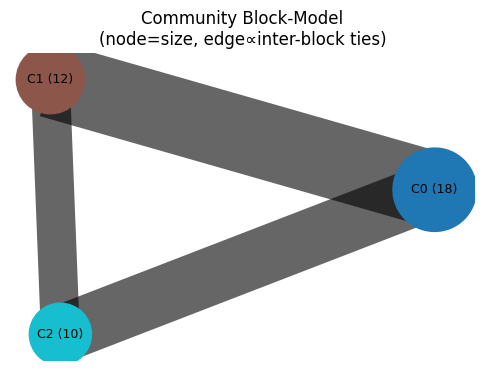

In [84]:
superG = nx.Graph()
for i,c in enumerate(comms):
    superG.add_node(i, size=len(c))
for u,v,d in G_thr.edges(data=True):
    cu,cv = node2comm[u], node2comm[v]
    if cu==cv: continue
    superG.add_edge(cu,cv, weight=superG.get_edge_data(cu,cv,{'weight':0})['weight']+d['weight'])

plt.figure(figsize=(6,4))
pos = nx.spring_layout(superG, weight='weight', seed=42)
sizes = [superG.nodes[i]['size']*200 for i in superG.nodes()]
nx.draw_networkx_nodes(superG,pos,node_size=sizes,node_color=list(superG.nodes()),cmap="tab10")
nx.draw_networkx_edges(superG,pos,width=[d['weight']/10 for _,_,d in superG.edges(data=True)],alpha=0.6)
nx.draw_networkx_labels(superG,pos,{i:f"C{i} ({superG.nodes[i]['size']})" for i in superG.nodes()},font_size=9)
plt.title("Community Block-Model\n(node=size, edge∝inter-block ties)")
plt.axis('off')
plt.show()


In [85]:
id2name  = {n:d['label'] for n,d in B.nodes(data=True) if d['bipartite']=='members'}
id2state = stock_tx[['member_id','state']].drop_duplicates().set_index('member_id')['state'].to_dict()
id2chamber = stock_tx[['member_id','chamber']].drop_duplicates().set_index('member_id')['chamber'].to_dict()
id2party = stock_tx[['member_id','party']].drop_duplicates().set_index('member_id')['party'].to_dict()

rows=[]
for i,c in enumerate(comms):
    for mid in sorted(c):
        rows.append({
            'Community': f"C{i}",
            'Name':       id2name[mid],
            'State':      id2state.get(mid,"—"),
            "Chamber":    id2chamber.get(mid),
            "Party":      id2party.get(mid)
        })
df_comms = pd.DataFrame(rows)
df_comms


,Community,Name,State,Chamber,Party
0,C0,Patrick Fallon,TX,House,R
1,C0,Bob Gibbs,OH,House,R
2,C0,Josh Gottheimer,NJ,House,D
3,C0,Marjorie Taylor Greene,GA,House,R
4,C0,Chris Jacobs,NY,House,R
5,C0,James R. Langevin,RI,House,D
6,C0,Susie Lee,NV,House,D
7,C0,Peter Meijer,MI,House,R
8,C0,Blake Moore,UT,House,R
9,C0,Marie Newman,IL,House,D


[frozenset({'R000305', 'L000559', 'J000020', 'W000800', 'M001213', 'G000563', 'M001186', 'L000590', 'S000185', 'S000250', 'S412', 'G000596', 'F000246', 'G000583', 'S408', 'S001216', 'S001201', 'N000192'}), frozenset({'M001205', 'L000397', 'R000609', 'S347', 'S372', 'A000372', 'S001180', 'K000389', 'L000579', 'J000305', 'Y000062', 'W000804'}), frozenset({'S247', 'M001157', 'C001114', 'M001180', 'K000375', 'H001082', 'P000616', 'C001101', 'P000197', 'M001135'})]


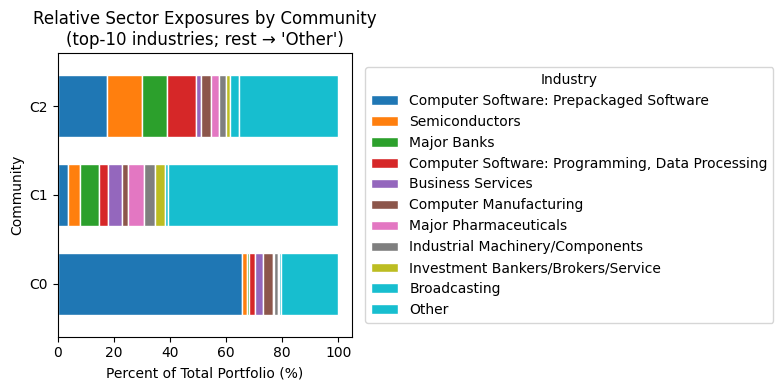

In [90]:
in_comm = set().union(*comms)
TOP_K = 10
tx = stock_tx[stock_tx['member_id'].isin(in_comm)].copy()
tx['Community'] = (
    tx['member_id']
      .map(node2comm)
      .astype(int)
      .map(lambda i: f"C{i}")
)

# — 6.2 Compute total $ by Community × Industry
sector_sum = (
    tx
    .groupby(['Community','industry'])['amount']
    .sum()
    .unstack(fill_value=0)
)

# — 6.3 Convert to fractions (relative exposures)
sector_frac = sector_sum.div(sector_sum.sum(axis=1), axis=0)

# — 6.4 Pick the global top-5 industries by total fraction
top_k = sector_frac.sum(axis=0).nlargest(TOP_K).index.tolist()

# — 6.5 Build a DataFrame with those + “Other”
sector_top_frac = sector_frac[top_k].copy()
sector_top_frac['Other'] = sector_frac.drop(columns=top_k).sum(axis=1)
sector_top_frac = sector_top_frac[top_k + ['Other']]

# — 6.6 (Optional) convert to percentages
sector_top10_pct = sector_top_frac * 100

# — 6.7 Plot horizontal stacked bar
ax = sector_top10_pct.plot(
    kind='barh',
    stacked=True,
    figsize=(8, 4),
    colormap='tab10',
    edgecolor='white',
    width=0.7
)
ax.set_xlabel("Percent of Total Portfolio (%)")
ax.set_title("Relative Sector Exposures by Community\n(top-10 industries; rest → 'Other')")
ax.legend(
    title="Industry",
    bbox_to_anchor=(1.02, 0.5),
    loc='center left'
)
plt.tight_layout()
plt.show()

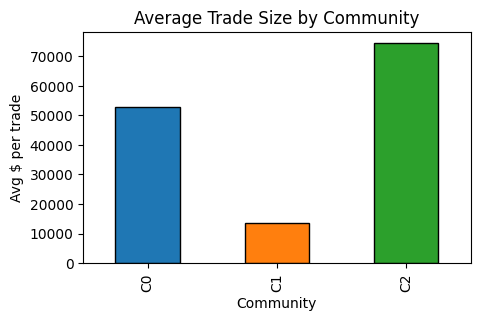

In [87]:
# %% 7.1 Compute stats
size_stats = tx.groupby('Community')['amount'].agg(['mean','median']).reindex()
size_stats

# %% 7.2 Plot
plt.figure(figsize=(5,3))
size_stats['mean'].plot(kind='bar', color=['C0','C1','C2','C3', 'C4', 'C5'], edgecolor='black')
plt.ylabel("Avg $ per trade")
plt.title("Average Trade Size by Community")
plt.show()


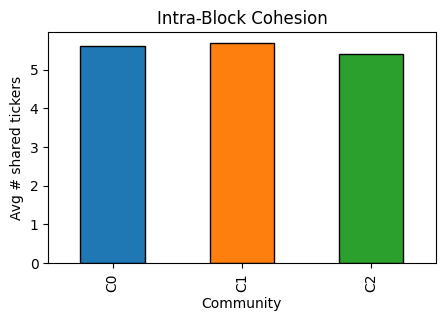

In [88]:
# %% 8.1 Build member–member weights matrix for each block
cohesion = []
for i,c in enumerate(comms):
    sub = G.subgraph(c)
    w = [d['weight'] for _,_,d in sub.edges(data=True)]
    cohesion.append({'Community':f"C{i}", 'mean_shared':np.mean(w), 'std_shared':np.std(w)})

df_cohesion = pd.DataFrame(cohesion).set_index('Community')
df_cohesion

# %% 8.2 Plot
plt.figure(figsize=(5,3))
df_cohesion['mean_shared'].plot(kind='bar', color=['C0','C1','C2','C3'], edgecolor='black')
plt.ylabel("Avg # shared tickers")
plt.title("Intra-Block Cohesion")
plt.show()
